# Installations and imports

In [1]:
#pip install yfinance

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re
import pprint
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns
from datetime import date,datetime
import locale
locale.setlocale(locale.LC_ALL, '')
import helper_functions as hp

# Important economic indicators

- https://www.finra.org/investors/insights/key-economic-indicators-every-investor-should-know

- https://www.investopedia.com/articles/personal-finance/020215/top-ten-us-economic-indicators.asp

- https://www.discoveroptions.com/mixed/content/education/articles/bigthreeeconomicindicators.html

# Retrievng major index and asset values - *Rapid API*
- S&P 500
- Dow 30
- Nasdaq
- Russell 2000
- Crude Oil
- FTSE 100
- Gold
- Bitcoin

In [2]:
index = ['S&P 500','Dow 30','Nasdaq','Russell 2000','Crude Oil','FTSE 100','Gold','Bitcoin']
tickers = ["^GSPC","^DJI","NQ=F","RTY=F","CL=F","^FTSE","GC=F","BTC-USD"]
index_current = []
index_change = []
indexes = pd.DataFrame()

for ticker in tickers: 
    data = hp.extract_stock_info(ticker)
    market_price = data['price']['regularMarketPrice']['raw']
    index_current.append(market_price)
    index_change.append(((market_price - data['price']['regularMarketOpen']['raw'])/market_price)*100)

indexes['Current'] = index_current
indexes['Change Percent'] = index_change
indexes['Index'] = index

print (indexes)

     Current  Change Percent         Index
0   4328.870       -0.306084       S&P 500
1  33614.800       -0.120869        Dow 30
2  13798.750       -1.959960        Nasdaq
3   1996.900       -1.782763  Russell 2000
4    115.000        6.121739     Crude Oil
5   6987.140       -3.602475      FTSE 100
6   1974.900        1.843131          Gold
7  39640.176        0.612903       Bitcoin


# Scraping Covid cases data - *Worldometer*
https://www.worldometers.info/coronavirus/country/us/

In [3]:
req = requests.get("https://www.worldometers.info/coronavirus/country/us/")
bs = BeautifulSoup(req.content)

div = bs.find_all('div')
cov_data = []

for i in div:
  if i.get('id') == "maincounter-wrap":
    cov_data.append(i)

In [4]:
cases = cov_data[0].find('h1')
cases = cases.text
cases_val = cov_data[0].find('span')
cases_val = cases_val.text

deaths = cov_data[1].find('h1')
deaths = deaths.text
deaths_val = cov_data[1].find('span')
deaths_val = deaths_val.text


rec = cov_data[2].find('h1')
rec = rec.text 
rec_val = cov_data[2].find('span')
rec_val = rec_val.text 

print (cases,':',cases_val)
print (deaths,':',deaths_val)
print (rec,':',rec_val)

cases = {'Cases':cases_val,'Deaths':deaths_val,'Recoveries':rec_val}

Coronavirus Cases: : 80,912,619 
Deaths: : 983,837
Recovered: : 54,594,944


# Scraping Covid vaccinations data - *New York Times*

https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html

In [5]:
req = requests.get("https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html")
bs = BeautifulSoup(req.content)
search = bs.find_all('td')

vac_labels = {'Atleast one shot':'pct_given_shot','Two shots (all)':'g-fully-vaccinated','Booster shot':'g-additional',
              'Total shots given':'g-hide-mobile','Two shots (65+)':'g-bar-col'}
vac_flag = [0,0,0,0,0]
atl_one_shot = 0
two_shots = 0
doses_del = 0
shots_given = 0
doses_used = 0
count = 0

for i in search: 
  cls = i.get('class')

  #The class names seem to have changed on the website so had to create an alternative parsing method by looking at different keywords in the class
  if cls[-1] == 'pct_given_shot':
    if vac_flag[0] == 0:
        atl_one_shot = i.text
        vac_flag[0] = 1
    else: 
        pass
  if cls[-2] == 'g-fully-vaccinated':
    if vac_flag[1] == 0:
        two_shots = i.text
        vac_flag[1] = 1
    else: 
        pass
  if cls[-1] == 'g-additional':
    if vac_flag[2] == 0:
        booster = i.text
        vac_flag[2] = 1
    else: 
        pass
  if cls[-2] == 'g-hide-mobile':
    if vac_flag[3] == 0:
        shots_given = i.text
        vac_flag[3] = 1
    else: 
        pass
  if cls[-1] == 'g-bar-col':
    count = count + 1
    if count == 4:
        elderly = i.text
        vac_flag[4] = 1
    else: 
        pass
  if sum(vac_flag) == 5:
    break
    
vac_values = [atl_one_shot,two_shots,booster,shots_given,elderly]
vac_values = list(map(str.strip,vac_values))

print ("At least one shot: ",vac_values[0])
print ("Two shots: ",vac_values[1])
print ("Booster shot: ",vac_values[2])
print("Total shots: ",vac_values[3])
print("Two shots 65+: ",vac_values[4])

At least one shot:  76%
Two shots:  65%
Booster shot:  29%
Total shots:  554,532,208
Two shots 65+:  89%


Note: The html text for the *class* attribute seemed to have changed on the NYT website. So the text used for parsing needed to be changed. The previous code containing the older parsing method is also shown above but commented out. 

# Extracting VIX Volatility Index data - *Yahoo Finance API*

### VIX Volatility Index

In [6]:
data = hp.extract_stock_info("^VIX")
vix = data['price']['regularMarketPrice']['raw']

# get stock info
print (vix)

31.98


# Scraping Treasury Yield Data - YCharts

- https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202203
- https://www.bloomberg.com/markets/rates-bonds/government-bonds/us

In [7]:
df_rates = hp.extract_treasury_rates('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202203')

df_rates.head()

,1mo,3mo,6mo,1yr,3yr,5yr,10yr,20yr,30yr
Date,,,,,,,,,
2022-03-01,0.11,0.32,0.60,0.91,1.47,1.56,1.72,2.19,2.11
2022-03-02,0.13,0.34,0.68,1.06,1.67,1.74,1.86,2.32,2.24
2022-03-03,0.19,0.38,0.69,1.08,1.69,1.74,1.86,2.32,2.24
2022-03-04,0.15,0.34,0.69,1.05,1.62,1.65,1.74,2.23,2.16


In [38]:
yield_curve = df_rates.iloc[0,:-1]
yield_curve

1mo     0.11
3mo     0.32
6mo     0.60
1yr     0.91
3yr     1.47
5yr     1.56
10yr    1.72
20yr    2.19
Name: 2022-03-01 00:00:00, dtype: float64

# Scraping unemployment rates - U.S. Bureau of Labor Statistics
https://data.bls.gov/timeseries/LNS14000000

In [39]:
req = requests.get('https://data.bls.gov/timeseries/LNS14000000')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search[6:]:
  count = count + 1
  time_list.append(count)
  rates.append(i.text)
  if count == 12: 
    years = years + 1
    count = 0 

year_list = []
for i in range(datetime.today().year-years+1,datetime.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_unemp_rate = pd.DataFrame()
df_unemp_rate['date'] = dates
df_unemp_rate['unemployment_rate_percent'] = rates  
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].str.strip()
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].replace('',np.nan)
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].apply(float)

df_unemp_rate.index = df_unemp_rate['date']
df_unemp_rate = df_unemp_rate.dropna()
df_unemp_rate.head()

,date,unemployment_rate_percent
date,,
2012-01-01,2012-01-01,8.3
2012-02-01,2012-02-01,8.3
2012-03-01,2012-03-01,8.2
2012-04-01,2012-04-01,8.2
2012-05-01,2012-05-01,8.2


# Scraping GDP data - U.S. Inflation Calculator
https://www.usinflationcalculator.com/inflation/historical-inflation-rates/

In [40]:
req = requests.get('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search:
  count = count + 1
  if count == 13:
    years = years + 1
    count = 0 
    continue
  time_list.append(count)
  rates.append(i.text)

time_list = time_list[:-6]
rates = rates[:-6]

year_list = []
for i in range(datetime.today().year-years+1,datetime.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_inflation = pd.DataFrame()
df_inflation['date'] = dates
df_inflation['inflation_rate'] = rates  
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].str.strip()
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].replace('',np.nan)

#Included additional steps to handle non-numeric inflation values
inflation_list = []
for rate in df_inflation['inflation_rate']: 
    try:
        inflation_list.append(float(rate))
    except: 
        inflation_list.append(float(np.nan))
        
df_inflation['inflation_rate'] = inflation_list

#Original code for converting inflation values to float
#df_inflation['inflation_rate'] = df_inflation['inflation_rate'].apply(float) 

df_inflation.index = df_inflation['date']
df_inflation = df_inflation.dropna()
df_inflation.head()

,date,inflation_rate
date,,
1914-01-01,1914-01-01,2.0
1914-02-01,1914-02-01,1.0
1914-03-01,1914-03-01,1.0
1914-04-01,1914-04-01,0.0
1914-05-01,1914-05-01,2.1


# Scraping Gross Domestic Product (GDP) - Multpl
https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year

In [41]:
req = requests.get('https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

dates = []
gdp = []

count = 0

for i in search: 
  count = count + 1
  if count == 1:
    dates.append(i.text)
  if count == 2: 
    gdp.append(i.text)
    count = 0

df_gdp = pd.DataFrame()
df_gdp['date'] = dates
df_gdp['date'] = df_gdp['date'].apply(pd.to_datetime)
df_gdp['gdp'] = gdp
df_gdp['gdp'] = df_gdp['gdp'].str.strip()
df_gdp['gdp'] = df_gdp['gdp'].str.extract('(\d+\D\d+)')
df_gdp['gdp'] = df_gdp['gdp'].apply(float)
df_gdp.index = df_gdp['date']
df_gdp.head()
    

,date,gdp
date,,
2021-12-31,2021-12-31,19.81
2020-12-31,2020-12-31,18.77
2019-12-31,2019-12-31,19.20
2018-12-31,2018-12-31,18.72
2017-12-31,2017-12-31,18.30


# Calculating Buffet Indicator

https://www.gurufocus.com/stock-market-valuations.php

https://www.gurufocus.com/shiller-PE.php

https://www.multpl.com/shiller-pe

##### $Buffet$ $indicator$ = $U.S.$ $Equity$ $Market$ $Value$ $/$ $U.S.$ $GDP$

1. Scraping Market Value of U.S. Stock Market - Siblis Research

https://siblisresearch.com/data/us-stock-market-value/#:~:text=The%20total%20market%20capitalization%20of,about%20OTC%20markets%20from%20here.

2. U.S. GDP - Extracted in the GDP section of this notebook

In [42]:
#Extracting the U.S. total market value
req = requests.get('https://siblisresearch.com/data/us-stock-market-value/#:~:text=The%20total%20market%20capitalization%20of,about%20OTC%20markets%20from%20here.')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

us_market_val = float(search[1].text.replace(',',''))*1000000
print ("U.S. Equity Maret Cap: $",us_market_val)
print ("U.S. GDP: $",df_gdp['gdp'].iloc[0]*1000000000000)

#Calculating Buffet Indicator
buffet_ind = np.round((us_market_val/(df_gdp['gdp'].iloc[0]*1000000000000))*100,2)
print ("Buffet indicator: ",buffet_ind,"%")

U.S. Equity Maret Cap: $ 53366436400000.0
U.S. GDP: $ 19810000000000.0
Buffet indicator:  269.39 %


# Extracting Shiller PE Ratio

https://www.gurufocus.com/shiller-PE.php

https://www.multpl.com/shiller-pe

In [43]:
#Extracting Shiller PE ratio
req = requests.get('https://www.multpl.com/shiller-pe')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('meta')

shiller_pe = float(re.findall('(\d+\d+.\d+\d+)',search[1].get('content'))[0])
print ("Shiller PE Ratio: ",shiller_pe)

Shiller PE Ratio:  35.43


# FINRA Margin Debt

https://www.finra.org/investors/learn-to-invest/advanced-investing/margin-statistics

https://www.advisorperspectives.com/dshort/updates/2021/08/12/margin-debt-and-the-market-down-4-3-in-july-first-decline-in-15-months

In [44]:
req = requests.get('https://www.finra.org/investors/learn-to-invest/advanced-investing/margin-statistics')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

date = []
debt = []

for i in search:
  if "Month/Year" in i.get('data-th'):
    date.append(i.text)
  if "Debit Balances" in i.get('data-th'):
    debt.append(i.text)

df_debt = pd.DataFrame()
df_debt['date'] = date
df_debt['debt'] = debt
df_debt['debt'] = df_debt['debt'].apply(lambda x: int(x.replace(',','')))
latest_data = df_debt[df_debt['date'].str.contains(r'-21')]

print ("Latest Margin Debt Data: ",list(latest_data['date'])[-1], ", $" + str(list(latest_data['debt'])[-1]*1000000))

df_debt.head()

Latest Margin Debt Data:  Dec-21 , $910021000000


,date,debt
0,Jan-22,829637
1,Jan-21,798605
2,Feb-21,813680
3,Mar-21,822551
4,Apr-21,847186


# Dashboard

Creating a grid to display all the information

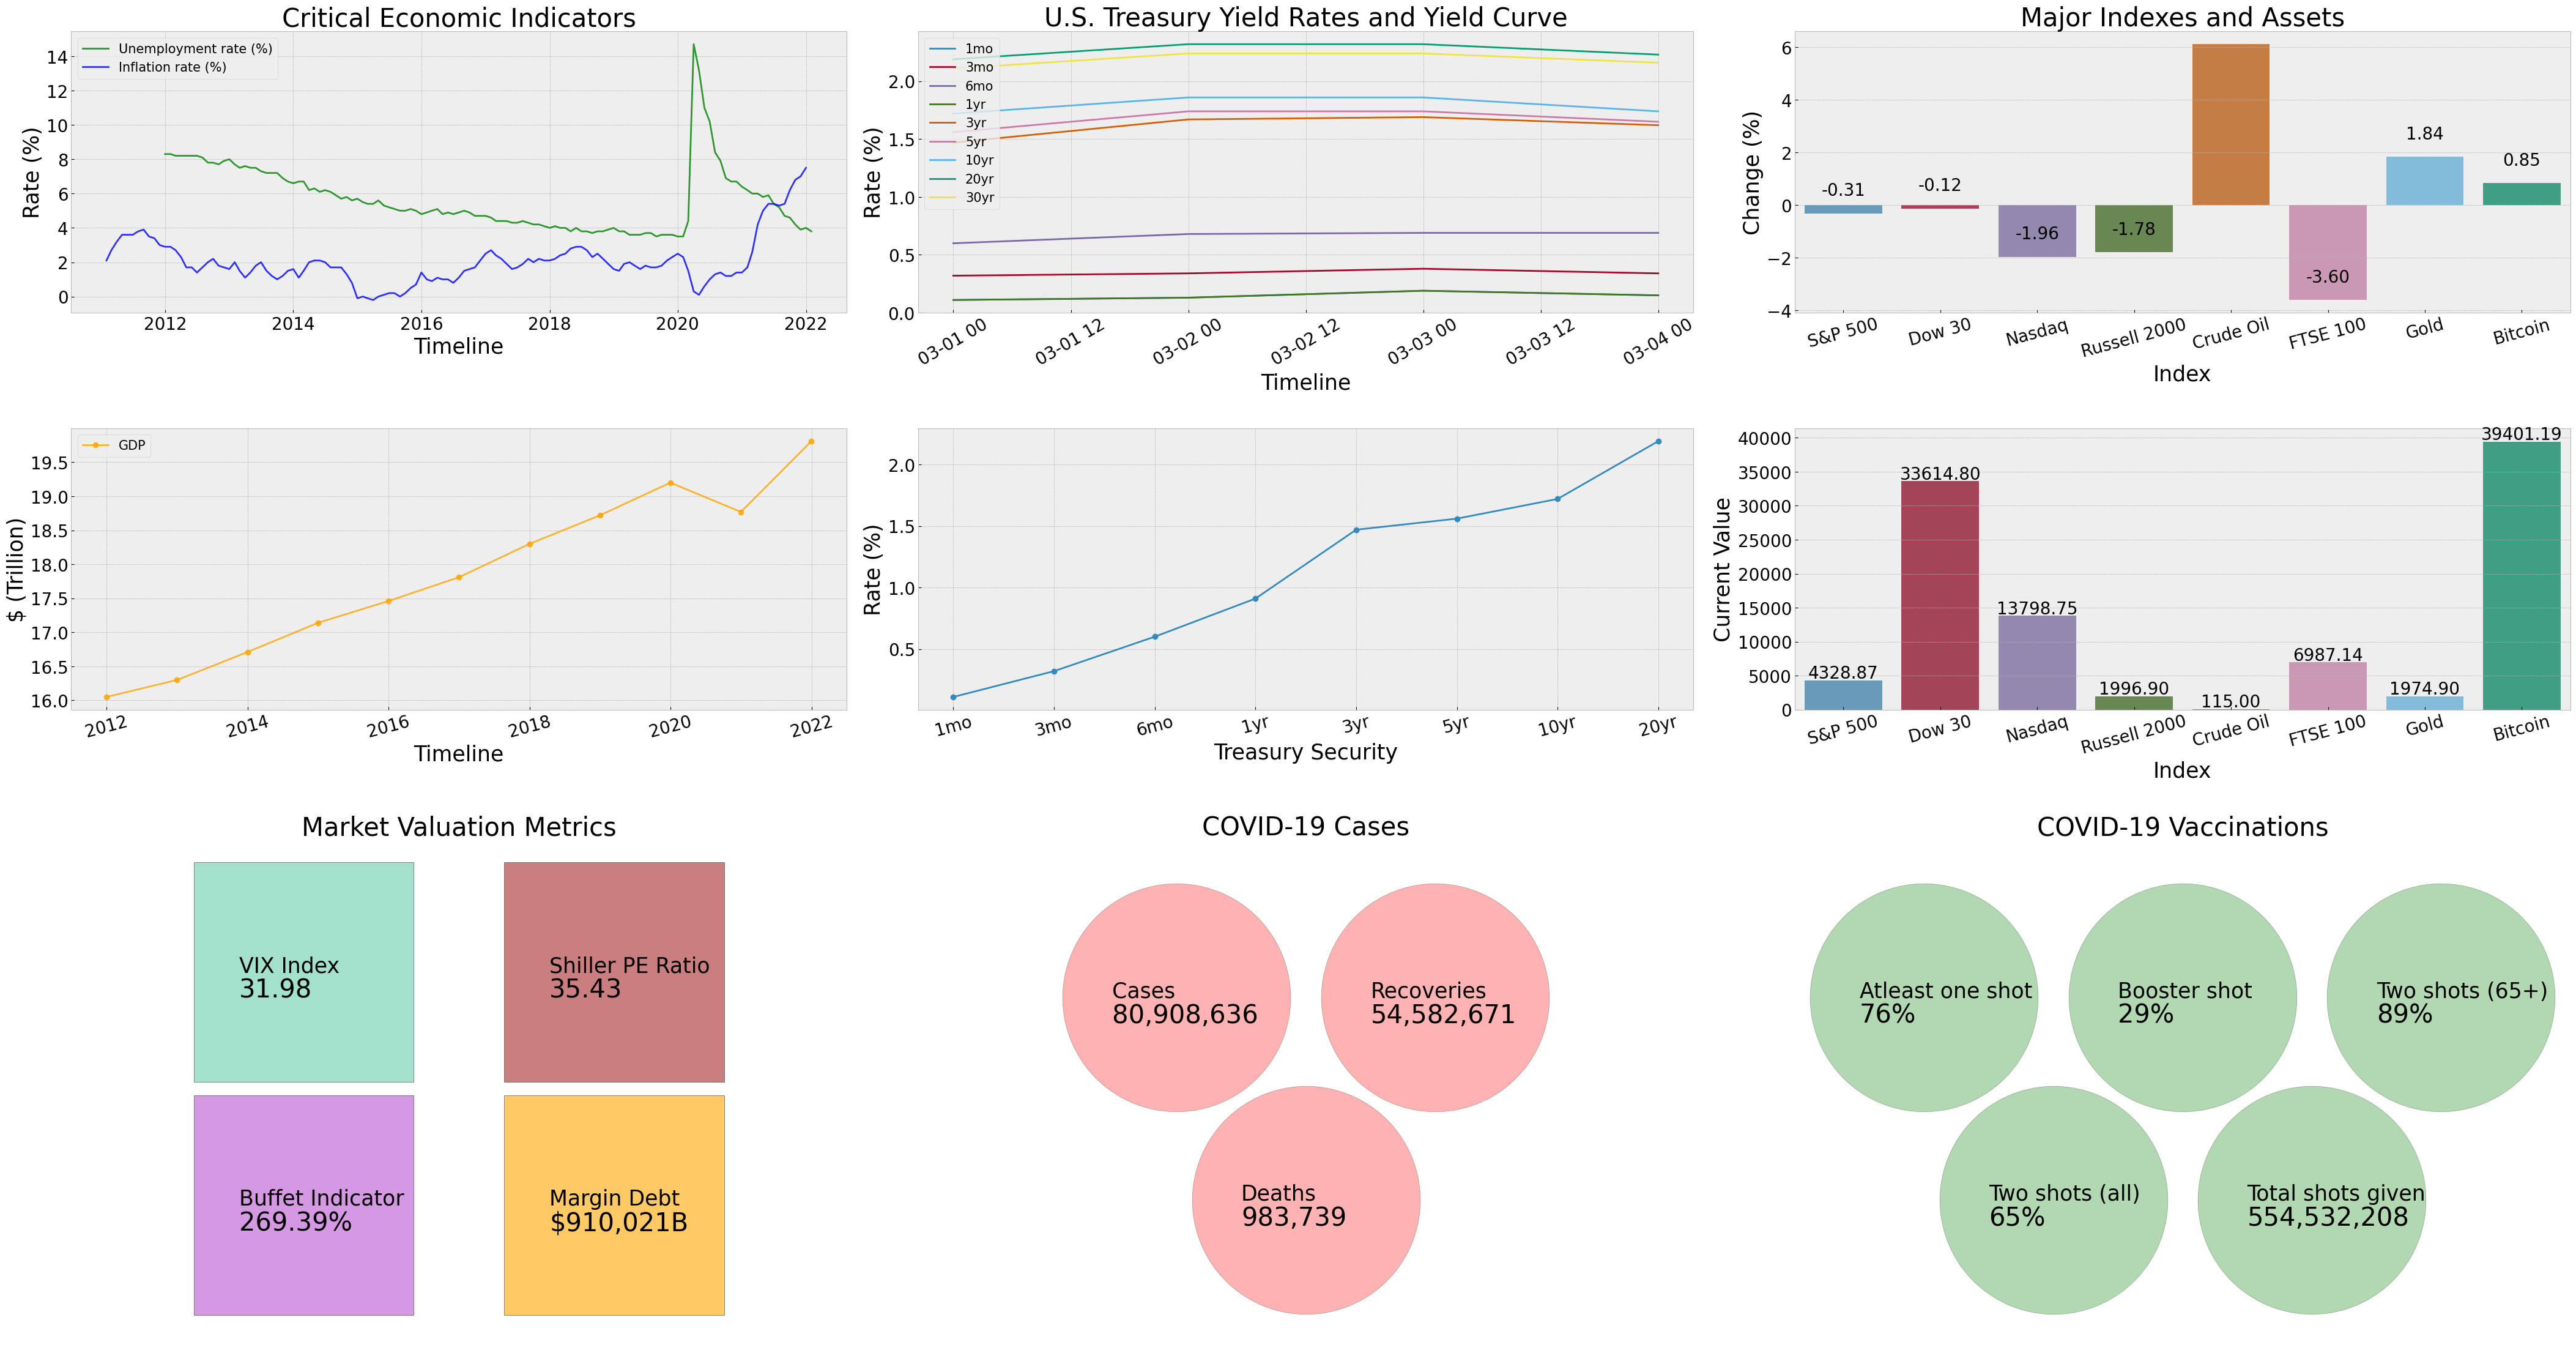

In [45]:
hp.dash_create(df_unemp_rate,df_gdp,df_inflation,df_rates,yield_curve,vix,indexes,cases,vac_values,vac_labels,buffet_ind,
              shiller_pe,df_debt,latest_data)